## Create dataloader

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import skimage
from data_loader import *

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
labels_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/labels.npy"
images_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/images.npy"
dataset = MyDataset(images_path, labels_path)
dataset_size = len(dataset)
print(dataset_size)

4981


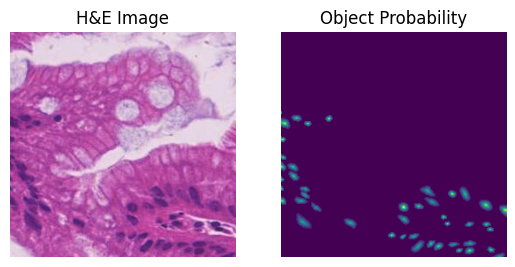

In [107]:
test_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0])
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()
